In [2]:
import random
import string
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import math
from matplotlib import rcParams, cm
rcParams['pdf.fonttype'] = 42

### Environment

In [3]:
scale = 1

goal_locations = {}
initial_position = np.array([3.0*scale, 0.0*scale])
symbols = list(string.ascii_lowercase) + ['$']
grid_size = (7*scale, 4*scale)
difference = 0
for i, symbol in enumerate(symbols):
    i+=difference
    row = (i // (grid_size[0]//scale))*scale
    col = (i % (grid_size[0]//scale))*scale
    if np.array_equal(initial_position, np.array([col, row])):
      difference =1
      i+=difference
      row = (i // (grid_size[0]//scale))*scale
      col = (i % (grid_size[0]//scale))*scale
    goal_locations[symbol] = np.array([float(col), float(row)])

grid_width, grid_height = 7 * scale, 4 * scale
resolution_x = int(160)
resolution_y = int(100)
x_vals = np.linspace(-1*scale, grid_width, resolution_x)
y_vals = np.linspace(-1*scale, grid_height, resolution_y)

plot_letters = ['$A$', '$B$', '$C$', '$D$', '$E$', '$F$',
                '$G$', '$H$', '$I$', '$J$', '$K$', '$L$',
                '$M$', '$N$', '$O$', '$P$', '$Q$', '$R$',
                '$S$', '$T$', '$U$', '$V$', '$W$', '$X$',
                '$Y$', '$Z$', '$EOS$']

### make data & learn N-gram

In [4]:
random.seed(82)
num_sample = 100000
def data_flower():
    all_flower = [
    'aster', 'aloe', 'azalea', 'amaryllis', 'broom', 'buttercup', 'begonia', 'bluebell', 'crocus', 'cosmos', 'camellia', 'clematis', 'daisy', 'dahlia', 'dogwood', 'delphinium','edelweiss', 'everlast', 'elm', 'epiphyllum', 'freesia', 'foxglove', 'fuchsia', 'fennel','geranium', 'gardenia', 'globe', 'gazania', 'hibiscus', 'heather', 'hyacinth', 'holly','iris', 'impatiens', 'ivy', 'indigo', 'jasmine', 'jacobinia', 'jonquil', 'jewelweed','kalmia', 'kerria', 'kalanchoe', 'knautia', 'lily', 'lotus', 'lavender', 'linaria','mallow', 'magnolia', 'mint', 'mallowleaf', 'nasturtium', 'narcissus', 'nicotiana', 'nemesia','orchid', 'oleander', 'oxeye', 'osmanthus', 'peony', 'poppy', 'petunia', 'primrose','quince', 'queen', 'quaker', 'quassia', 'rose', 'ranunculus', 'rue', 'rockrose','snapdragon', 'stock', 'sunflower', 'snowdrop', 'tulip', 'thyme', 'tansy', 'toadflax', 'umbrella', 'ursinia', 'utricularia', 'ulex', 'violet', 'veronica', 'vinca', 'valerian','wisteria', 'wallflower', 'waxplant', 'wintergreen', 'xeranthemum', 'xylosma', 'xenia', 'xyris', 'yucca', 'yellowbell', 'yarrow', 'yerba', 'zinnia', 'zephyr', 'zantedeschia', 'zigadenus'
    ]

    weights_color = [
    12, 3, 15, 17, 4, 13, 15, 10, 12, 13, 9, 14, 8, 18, 6, 11, 3, 2, 1, 17, 15, 14, 20, 2, 12, 4, 5, 20, 18, 10, 14, 3, 11, 12, 1, 9, 6, 11, 8, 13, 10, 9, 14, 12, 8, 9, 10, 13, 11, 7, 2, 3, 16, 15, 7, 12, 19, 10, 8, 5, 18, 17, 16, 13, 8, 6, 4, 3, 20, 18, 3, 9, 17, 8, 13, 2, 19, 4, 6, 12, 2, 10, 5, 6, 10, 9, 11, 8, 11, 13, 4, 3, 7, 1, 8, 5, 4, 12, 6, 3, 19, 9, 17, 6
    ]

    data1 = random.choices(all_flower, weights=weights_color, k=num_sample)

    max_weight = max(weights_color)
    weights_color_ = [max_weight - w + 1 for w in weights_color]

    data2 = random.choices(all_flower, weights=weights_color_, k=num_sample)

    return data1, data2, all_flower, weights_color

# N-gram
class CharNGramModel:
    def __init__(self, n):
        self.n = n
        self.model = defaultdict(Counter)
        self.alphabet = list(string.ascii_lowercase) + ['$']  # a〜z + EOS

    def train(self, names):
        for name in names:
            name = '^' * (self.n-1) + name.lower() + '$'
            for i in range(len(name) - self.n + 1):
                context = name[i:i+self.n-1]
                next_char = name[i+self.n-1]
                self.model[context][next_char] += 1

    def get_probabilities(self, context, smoothing=1e-9):
        next_chars = self.model.get(context, {})
        smoothed_counts = {
            char: next_chars.get(char, 0) + smoothing for char in self.alphabet
        }
        total = sum(smoothed_counts.values())
        return {char: count / total for char, count in smoothed_counts.items()}

In [5]:
N=6
init_context = '^' * (N-1)
data1, data2, all_flower, weights_color = data_flower()

# Train language model
model1 = CharNGramModel(N)
model1.train(data1)
model2 = CharNGramModel(N)
model2.train(data2)

### Fig1 left

(-1.0, 4.0)

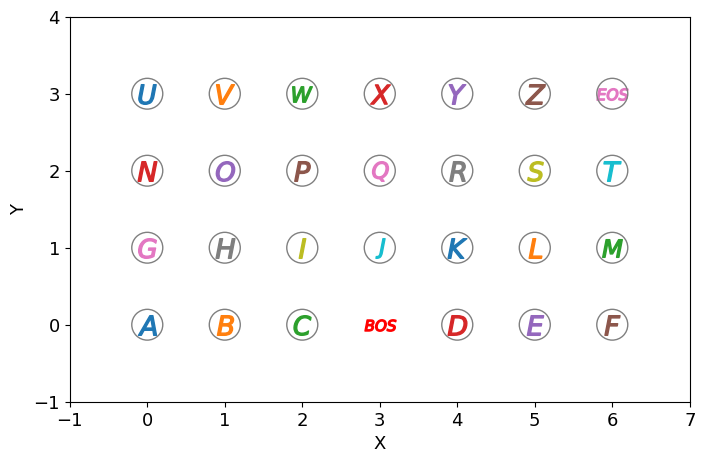

In [6]:
r_0 = 0.2*scale
fig, ax = plt.subplots(figsize=(8, 5))

for i, (symbol, goal) in enumerate(goal_locations.items()):
  if i == 26:
    ax.scatter(goal[0], goal[1], marker=plot_letters[i], s=500)
  else:
    ax.scatter(goal[0], goal[1], marker=plot_letters[i], s=200)

  circle = Circle(goal, r_0, fill=False, edgecolor='gray')
  ax.add_patch(circle)

ax.scatter(initial_position[0], initial_position[1], marker='$BOS$', color='red', s=500)

ax.set_xlabel("X", size=13)
ax.set_ylabel("Y", size=13)
ax.tick_params(labelsize=13)
ax.set_xlim(-1*scale, grid_size[0])
ax.set_ylim(-1*scale, grid_size[1])

### Fig1 right

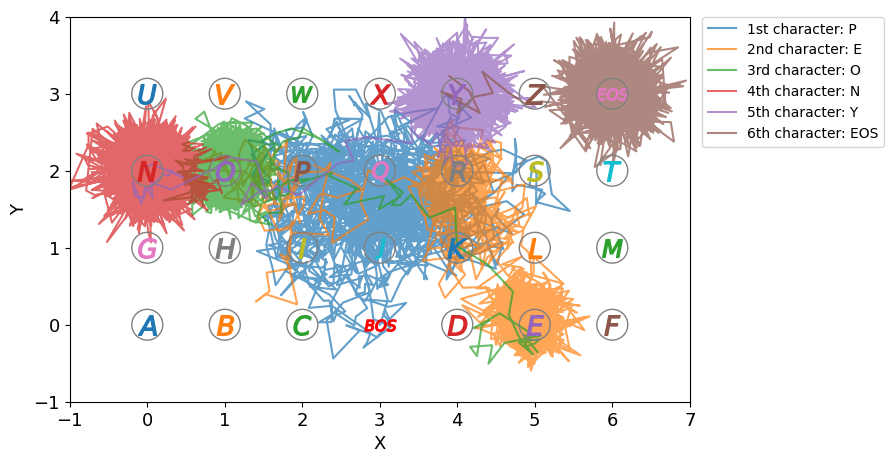

In [7]:
r_0 = 0.2
down_samp = 1
alpha = 0.7
fig, ax = plt.subplots(figsize=(8, 5))
path = "/content/peony_trajectory.npy"
trajectories = np.load(path)
trajectoryies = np.array(trajectories)
legends = [ '1st character: P', '2nd character: E',
    '3rd character: O', '4th character: N',
    '5th character: Y', '6th character: EOS']

for j, trajectory in enumerate(trajectories):
  ax.plot(trajectory[::down_samp, 0], trajectory[::down_samp, 1], zorder=1, label=legends[j], alpha=alpha)

for i, (symbol, goal) in enumerate(goal_locations.items()):
  if i == 26:
    ax.scatter(goal[0], goal[1], marker=plot_letters[i], s=500, zorder=2)
  else:
    ax.scatter(goal[0], goal[1], marker=plot_letters[i], s=200, zorder=2)

  circle = Circle(goal, r_0, fill=False, edgecolor='gray', zorder=2)
  ax.add_patch(circle)

ax.scatter(initial_position[0], initial_position[1], marker='$BOS$', color='red', s=500, zorder=2)

ax.set_xlabel("X", size=13)
ax.set_ylabel("Y", size=13)
ax.tick_params(labelsize=13)
ax.set_xlim(-1*scale, grid_size[0])
ax.set_ylim(-1*scale, grid_size[1])
ax.legend(loc="upper left",bbox_to_anchor=(1.02, 1.0,), borderaxespad=0)

### Table1

In [8]:
Agent1_result =  [('petunia', 23), ('jacobinia', 18), ('quince', 13), ('iris', 12), ('impatiens', 8), ('kalmia', 8), ('rose', 7), ('orchid', 4), ('dahlia', 2), ('begonia', 1), ('hibiscus', 1), ('kalanchoe', 1), ('peony', 1), ('jewelweed', 1)]
Agent2_result = [('quassia', 31), ('quaker', 14), ('jacobinia', 13), ('primrose', 8), ('kalmia', 7), ('ivy', 5), ('rue', 4), ('xylosma', 4), ('petunia', 3), ('jasmine', 3), ('kerria', 2), ('osmanthus', 2), ('rockrose', 1), ('lily', 1), ('yerba', 1), ('dogwood', 1)]
Agent12_result = [('quaker', 27), ('jacobinia', 21), ('petunia', 15), ('iris', 10), ('rockrose', 7), ('kalmia', 6), ('ivy', 3), ('quince', 3), ('osmanthus', 2), ('quassia', 2), ('daisy', 1), ('impatiens', 1), ('indigo', 1), ('snapdragon', 1)]

#### Table1 results

In [9]:
probs1 = []
for w, num in Agent1_result:
  context = init_context + w + '$'
  p = 1
  for i in range(len(context)-N+1):
    p = p * model1.get_probabilities(context[i:i+N-1])[context[i+N-1]]
  probs1.append((w, p))
print(probs1)

[('petunia', 0.015689999998516765), ('jacobinia', 0.011059999997940516), ('quince', 0.007899999998770372), ('iris', 0.010519999999142998), ('impatiens', 0.012109999997829851), ('kalmia', 0.009589999998961849), ('rose', 0.019859999999205593), ('orchid', 0.018389999998589233), ('dahlia', 0.017799999998677332), ('begonia', 0.014659999998352144), ('hibiscus', 0.018019999998079492), ('kalanchoe', 0.014159999998054066), ('peony', 0.017339999999016437), ('jewelweed', 0.012669999997838197)]


In [10]:
probs2 = []
for w, num in Agent2_result:
  context = init_context + w + '$'
  p = 1
  for i in range(len(context)-N+1):
    p = p * model2.get_probabilities(context[i:i+N-1])[context[i+N-1]]
  probs2.append((w, p))
print(probs2)

[('quassia', 0.015309999998683278), ('quaker', 0.014369999998960879), ('jacobinia', 0.008729999998023727), ('primrose', 0.006779999998087446), ('kalmia', 0.009319999998823537), ('ivy', 0.0173099999993827), ('rue', 0.0157699999993468), ('xylosma', 0.016349999998489385), ('petunia', 0.004409999998483157), ('jasmine', 0.012689999998468295), ('kerria', 0.010089999998626633), ('osmanthus', 0.014559999997824473), ('rockrose', 0.010469999998111885), ('lily', 0.011549999999245582), ('yerba', 0.015379999998976416), ('dogwood', 0.012679999998353)]


In [11]:
probs12 = []
for w, num in Agent12_result:
  context = init_context + w + '$'
  p = 1
  for i in range(len(context)-N+1):
    agent1_p = list(model1.get_probabilities(context[i:i+N-1]).values())
    agent2_p = list(model2.get_probabilities(context[i:i+N-1]).values())
    sqrt_p = np.sqrt(np.array(agent1_p) * np.array(agent2_p))
    z = np.sum(sqrt_p)
    temp_p = (1/z) * sqrt_p

    target_c = [c_id for c_id, c in enumerate(symbols) if c == context[i+N-1]]
    p = p * temp_p[target_c[0]]
  probs12.append((w, float(p)))
print(probs12)

[('quaker', 0.008380925032042498), ('jacobinia', 0.010696980266715547), ('petunia', 0.008896328659361895), ('iris', 0.011246442169858465), ('rockrose', 0.016473622385585425), ('kalmia', 0.010149294422239757), ('ivy', 0.004712678319056495), ('quince', 0.010092492159414386), ('osmanthus', 0.010078916716457232), ('quassia', 0.006962356624343816), ('daisy', 0.012116615267159596), ('impatiens', 0.01147313235403875), ('indigo', 0.01175288907380189), ('snapdragon', 0.01162438425187542)]


### Fig. 5

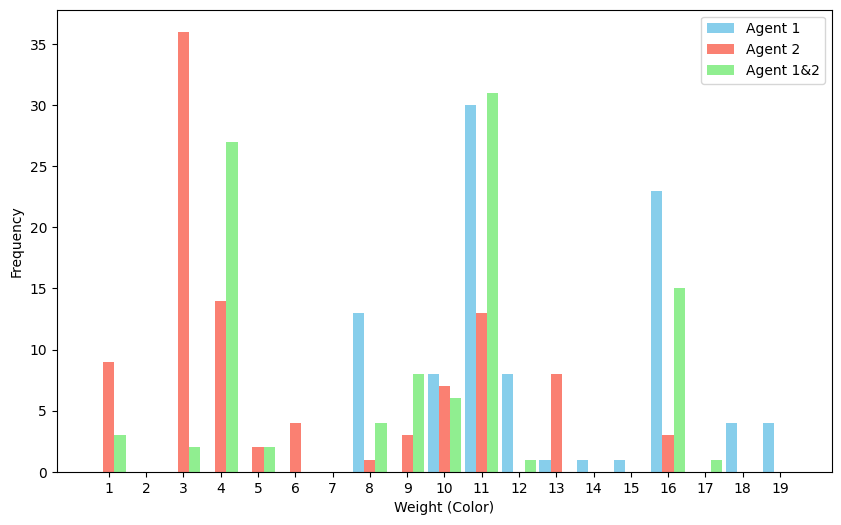

In [12]:
weight_map = {flower: weight for flower, weight in zip(all_flower, weights_color)}

agg_freq1 = defaultdict(int)
for aget1_r in Agent1_result:
  weight_l = [weight for flower, weight in weight_map.items() if flower == aget1_r[0]]
  agg_freq1[weight_l[0]] += aget1_r[1]

agg_freq2 = defaultdict(int)
for aget2_r in Agent2_result:
  weight_l = [weight for flower, weight in weight_map.items() if flower == aget2_r[0]]
  agg_freq2[weight_l[0]] += aget2_r[1]

agg_freq12 = defaultdict(int)
for aget12_r in Agent12_result:
  weight_l = [weight for flower, weight in weight_map.items() if flower == aget12_r[0]]
  agg_freq12[weight_l[0]] += aget12_r[1]

sorted_weights = np.arange(1,20)
freqs1 = [agg_freq1[w] for w in sorted_weights]
freqs2 = [agg_freq2[w] for w in sorted_weights]
freqs12 = [agg_freq12[w] for w in sorted_weights]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3
x = np.arange(len(sorted_weights))
plt.bar(x - bar_width, freqs1, width=bar_width, label='Agent 1', color='skyblue')
plt.bar(x, freqs2, width=bar_width, label='Agent 2', color='salmon')
plt.bar(x + bar_width, freqs12, width=bar_width, label='Agent 1&2', color='lightgreen')
plt.xlabel('Weight (Color)')
plt.ylabel('Frequency')
plt.xticks(x, sorted_weights)
plt.legend()

### Table 2

In [13]:
Results = [Agent1_result, Agent2_result, Agent12_result]
eps=1e-200
for Agent_result in Results:
  perplexities = {}
  calc_p = 0
  probs = []
  for w, num in Agent_result:
    context = init_context + w + '$'
    p = 1
    count = 0
    log_prob_sum = 0.0
    for i in range(len(context)-N+1):
      p_ = model1.get_probabilities(context[i:i+N-1])[context[i+N-1]]
      p *= p_
      log_prob_sum += math.log2(p_ + eps)
      count += 1

    probs.append((w, float(p)))
    avg_log_prob = log_prob_sum / count
    perplexity = 2 ** (- avg_log_prob)

    perplexities[w] = perplexity
    calc_p += perplexity * num
  print("calc perplexity 1&2", calc_p/100)
  print(probs)

calc perplexity 1&2 1.8494301408037688
[('petunia', 0.015689999998516765), ('jacobinia', 0.011059999997940516), ('quince', 0.007899999998770372), ('iris', 0.010519999999142998), ('impatiens', 0.012109999997829851), ('kalmia', 0.009589999998961849), ('rose', 0.019859999999205593), ('orchid', 0.018389999998589233), ('dahlia', 0.017799999998677332), ('begonia', 0.014659999998352144), ('hibiscus', 0.018019999998079492), ('kalanchoe', 0.014159999998054066), ('peony', 0.017339999999016437), ('jewelweed', 0.012669999997838197)]
calc perplexity 1&2 2.2479522361406374
[('quassia', 0.002739999998798557), ('quaker', 0.00422999999896532), ('jacobinia', 0.011059999997940516), ('primrose', 0.012929999998132536), ('kalmia', 0.009589999998961849), ('ivy', 0.0008899999994826394), ('rue', 0.003069999999473215), ('xylosma', 0.0008799999986558249), ('petunia', 0.015689999998516765), ('jasmine', 0.005919999998576461), ('kerria', 0.009439999998652731), ('osmanthus', 0.004679999997899273), ('rockrose', 0.009

In [14]:
Results = [Agent1_result, Agent2_result, Agent12_result]
eps=1e-200
for Agent_result in Results:
  perplexities = {}
  calc_p = 0
  probs = []
  for w, num in Agent_result:
    context = init_context + w + '$'
    p = 1
    count = 0
    log_prob_sum = 0.0
    for i in range(len(context)-N+1):
      p_ = model2.get_probabilities(context[i:i+N-1])[context[i+N-1]]
      p *= p_
      log_prob_sum += math.log2(p_ + eps)
      count += 1

    probs.append((w, float(p)))
    avg_log_prob = log_prob_sum / count
    perplexity = 2 ** (- avg_log_prob)

    perplexities[w] =  perplexity
    calc_p += perplexity * num
  print("calc perplexity 1&2", calc_p/100)
  print(probs)

calc perplexity 1&2 2.129585703696413
[('petunia', 0.004409999998483157), ('jacobinia', 0.008729999998023727), ('quince', 0.011329999998857067), ('iris', 0.008339999999178309), ('impatiens', 0.00753999999788327), ('kalmia', 0.009319999998823537), ('rose', 0.0007299999994664241), ('orchid', 0.0017299999986974696), ('dahlia', 0.0025399999989038713), ('begonia', 0.0050199999984128964), ('hibiscus', 0.0025299999981692653), ('kalanchoe', 0.005389999998214939), ('peony', 0.0027499999990885423), ('jewelweed', 0.007099999997880953)]
calc perplexity 1&2 1.8399491040032916
[('quassia', 0.015309999998683278), ('quaker', 0.014369999998960879), ('jacobinia', 0.008729999998023727), ('primrose', 0.006779999998087446), ('kalmia', 0.009319999998823537), ('ivy', 0.0173099999993827), ('rue', 0.0157699999993468), ('xylosma', 0.016349999998489385), ('petunia', 0.004409999998483157), ('jasmine', 0.012689999998468295), ('kerria', 0.010089999998626633), ('osmanthus', 0.014559999997824473), ('rockrose', 0.0104

In [15]:
Results = [Agent1_result, Agent2_result, Agent12_result]
eps=1e-200
peony_ws_1 = []
peony_ws_2 = []

for Agent_result in Results:
  perplexities = {}
  calc_p = 0
  probs = []
  for w, num in Agent_result:
    context = init_context + w + '$'
    p = 1
    count = 0
    log_prob_sum = 0.0
    for i in range(len(context)-N+1):
      agent1_p = list(model1.get_probabilities(context[i:i+N-1]).values())
      agent2_p = list(model2.get_probabilities(context[i:i+N-1]).values())
      sqrt_p = np.sqrt(np.array(agent1_p) * np.array(agent2_p))
      z = np.sum(sqrt_p)
      temp_p = (1/z) * sqrt_p

      target_c = [c_id for c_id, c in enumerate(symbols) if c == context[i+N-1]]
      p_ = temp_p[target_c[0]]
      p = p * p_

      log_prob_sum += math.log2(p_ + eps)
      count += 1

      if w == "peony":
        peony_ws_1.append(agent1_p)
        peony_ws_2.append(agent2_p)

    probs.append((w, float(p)))
    avg_log_prob = log_prob_sum / count
    perplexity = 2 ** (- avg_log_prob)

    perplexities[w] =  perplexity
    calc_p += perplexity * num
  print("calc perplexity 1&2", calc_p/100)
  print(probs)

calc perplexity 1&2 1.9259388625140093
[('petunia', 0.008896328659361895), ('jacobinia', 0.010696980266715547), ('quince', 0.010092492159414386), ('iris', 0.011246442169858465), ('impatiens', 0.01147313235403875), ('kalmia', 0.010149294422239757), ('rose', 0.006286031594988011), ('orchid', 0.006886906054641422), ('dahlia', 0.008436283362201771), ('begonia', 0.009732205870902523), ('hibiscus', 0.008393995026585551), ('kalanchoe', 0.00937874225169655), ('peony', 0.007385347686027198), ('jewelweed', 0.010012388969166125)]
calc perplexity 1&2 1.9864840686967085
[('quassia', 0.006962356624343816), ('quaker', 0.008380925032042498), ('jacobinia', 0.010696980266715547), ('primrose', 0.009912938886349818), ('kalmia', 0.010149294422239757), ('ivy', 0.004712678319056495), ('rue', 0.008731517021282522), ('xylosma', 0.004474773410922078), ('petunia', 0.008896328659361895), ('jasmine', 0.009435570713294705), ('kerria', 0.010196521022091712), ('osmanthus', 0.010078916716457232), ('rockrose', 0.016473

### Fig. 6

In [16]:
#D=T*eta
T = [0.0, 0.1, 0.2 ,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

Result_t00 = [('quince', 100)]
Result_t01 = [('quaker', 24), ('jacobinia', 16), ('iris', 13), ('petunia', 12), ('kalmia', 11), ('rockrose', 7), ('quassia', 7), ('indigo', 2), ('snapdragon', 2), ('osmanthus', 1), ('quince', 1), ('ivy', 1), ('hibiscus', 1), ('ioqjjprqqqqkwjqiikrjr', 1), ('wallflower', 1)]
Result_t02 = [('petunia', 10), ('quaker', 10), ('jacobinia', 9), ('kalmia', 8), ('rockrose', 7), ('quince', 5), ('jasmine', 5), ('ivy', 5), ('quassia', 5), ('iris', 4), ('indigo', 4), ('primrose', 3), ('wallflower', 3), ('daisy', 2), ('snowdrop', 2), ('xyris', 2), ('snapdragon', 2), ('hibiscus', 2), ('kghjjjqqjrqiqqijpqjpo', 1), ('hyacinth', 1), ('cosmos', 1), ('vinca', 1), ('osmanthus', 1), ('yellowbell', 1), ('xeranthemum', 1), ('hphjjkcqwqrrqpkprjjpi', 1), ('kalanchoe', 1), ('iqjjqkprcpqrojkrkorpp', 1), ('narcissus', 1), ('xenia', 1)]
Result_t03 = [('quaker', 9), ('petunia', 7), ('jacobinia', 5), ('rockrose', 5), ('jasmine', 4), ('kalmia', 4), ('yellowbell', 4), ('osmanthus', 4), ('daisy', 3), ('orchid', 3), ('epiphyllum', 3), ('primrose', 3), ('bluebell', 3), ('xenia', 3), ('quassia', 2), ('quince', 2), ('kalanchoe', 2), ('linaria', 2), ('snapdragon', 2), ('waxplant', 2), ('cosmos', 2), ('mallow', 1), ('camellia', 1), ('umbrella', 1), ('wisteria', 1), ('ixdjijykjjyjrhdptxxyi', 1), ('edelweiss', 1), ('zjzyjiqzqdtjcxxljirby', 1), ('peony', 1), ('iwrhapqxrjkqsllqnkj', 1), ('rose', 1), ('ivy', 1), ('impatiens', 1), ('qudlqwryrqpjqrjkdfoad', 1), ('jbhovscpxjrixrjetadri', 1), ('ierkqirrxwcicorcyjcro', 1), ('jkwppysjcrqqrdwerdqkd', 1), ('wallflower', 1), ('dogwood', 1), ('crocus', 1), ('lily', 1), ('xeranthemum', 1), ('hibiscus', 1), ('hyacinth', 1), ('qugipnjxqnqkwdqgjjika', 1), ('indigo', 1), ('ckpqbsrcriqkcgkqbqlkh', 1)]
Result_t04 = [('jacobinia', 9), ('petunia', 8), ('osmanthus', 3), ('crocus', 3), ('rockrose', 3), ('indigo', 2), ('wisteria', 2), ('violet', 2), ('lily', 2), ('linaria', 2), ('orchid', 2), ('iris', 2), ('quaker', 2), ('jasmine', 2), ('bluebell', 2), ('quassia', 1), ('daisy', 1), ('cfpkvrbyggrqqjjzsicjp', 1), ('jadjxlcswrmkbzxybjaso', 1), ('jakxdbcjysqcpsqfdqtjf', 1), ('xeranthemum', 1), ('dbwuhrikxwjddyjqjarml', 1), ('pdrsdhgsgaqdsyawdbyjp', 1), ('foxglove', 1), ('flrryjjpqodcxwjxasqqk', 1), ('fvcdbpjhqwrqdsypikkhc', 1), ('primrose', 1), ('iohxytcgzjuqdnrycycrq', 1), ('ygjyqcfcqpjqwaxqjxjlj', 1), ('clefyrsjcsjjdzgbleixp', 1), ('mallow', 1), ('hxiprzjirhchzjfcpcklo', 1), ('ecxkjkwclrrycdspesyj', 1), ('lhvqkpjjkdjkjrnwrkjik', 1), ('geranium', 1), ('thyme', 1), ('ulex', 1), ('', 1), ('nicotiana', 1), ('pmxlkxnm', 1), ('kalfrdwibixldrrjpljzm', 1), ('pe', 1), ('epiphyllum', 1), ('bkiqjjxcazymtcyjxqjqr', 1), ('rnvjcxidqjxyjqpaidsyj', 1), ('chsjzjbpxjidzroctjhxj', 1), ('jgpdivacqqjoyqizhkrbp', 1), ('cdqpwpfdwjrhyefqwgxpy', 1), ('lavender', 1), ('nemesia', 1), ('kerria', 1), ('xzkjrbdlqdyxpurkwpoum', 1), ('ckyjpsgiwzmdxhqpjqckq', 1), ('snapdragon', 1), ('qualahqwwkdyqwqvwkxdj', 1), ('zigadenus', 1), ('gdcqdojcfpcjjqvhxsjtv', 1), ('cosmos', 1), ('yerba', 1), ('flvzqxayrjjtrqqawkyxc', 1), ('oleander', 1), ('gardenia', 1), ('rvocc', 1), ('xyris', 1), ('cgfrpjqqnkxp', 1), ('jafjc', 1), ('xenia', 1), ('toadflax', 1), ('cjaakphjjwxifa', 1)]
Result_t05 = [('xyris', 4), ('xenia', 3), ('dahlia', 3), ('crocus', 3), ('quaker', 3), ('kalanchoe', 3), ('daisy', 3), ('yellowbell', 2), ('rockrose', 2), ('wallflower', 2), ('nicotiana', 2), ('ulex', 2), ('petunia', 2), ('rue', 2), ('rnj', 1), ('cppjsdwnufud', 1), ('ccqdncrfjlfivjqyxtpki', 1), ('qubqcjw', 1), ('perwkga', 1), ('rguqsiftdtafgm', 1), ('xeptjjixcuhmq', 1), ('jewelweed', 1), ('qudoeyvvmjyqjjgqlvi', 1), ('ylmdxcfwoiddcurrujpdx', 1), ('itxrckqxyx', 1), ('clematis', 1), ('txj', 1), ('atkacncjuwswyjopqmajm', 1), ('epiphyllum', 1), ('iris', 1), ('hjaddpxwcsiricrqdovlj', 1), ('wallflowdujjyyoxcjjvd', 1), ('indigo', 1), ('narcis', 1), ('whjiilhayjdskqcovhvya', 1), ('tnvc', 1), ('lclqyiqrxyavflqhyhtbg', 1), ('izcxjmudrkshqcdjxxtcq', 1), ('bluebell', 1), ('cwooiqqrarrauqxcdccjl', 1), ('iuraxvecjfxeezmiwblmo', 1), ('kamxpxyjepdzgziupjcqu', 1), ('jakqsvjdpw', 1), ('dgdyuqsxyruihtlxixdpd', 1), ('freesia', 1), ('iyjqkkqdokcvucdutjgrd', 1), ('dkeqocjnjomyqp', 1), ('ma', 1), ('aloe', 1), ('quc', 1), ('bkdkispwijpharwnjlspx', 1), ('jjyijcaxaqiqypzkcyaek', 1), ('dgpijkbopjllyjgouqkcl', 1), ('queen', 1), ('cdpscdoxdavdisqjtp', 1), ('wisteria', 1), ('igyypgxzvxdcscdiixcwc', 1), ('xdxprsdqwfphxquvocszy', 1), ('cuslzxy', 1), ('warrgthkoxkjfdcxlzhdp', 1), ('pctwyqijqutjuwjbydfwp', 1), ('orchid', 1), ('bgtdjwf', 1), ('cjqdipniidjxoycqizchj', 1), ('xevpswdpqwedxrejdfjqx', 1), ('ilvjxjbvjpcqdevhjlmdy', 1), ('daisyvtekncxnxfyrjjzw', 1), ('pcqccjwddoqctqfsakqdi', 1), ('waypcceyybquycxyucjy', 1), ('cbdpvqiz', 1), ('qubykdaldiujr', 1), ('waxplant', 1), ('ecxq', 1), ('', 1), ('jasmine', 1), ('knautia', 1), ('violet', 1), ('yellowcmxcgoc', 1)]
Result_t06 = [('jacobinia', 4), ('daisy', 3), ('dogwood', 2), ('', 2), ('crocus', 2), ('vinca', 2), ('xeukdc', 1), ('ycwzsjjmtpuldmmw', 1), ('thyme', 1), ('xeocxukpkwad', 1), ('quince', 1), ('licxzlcwxipcbnnmdgggd', 1), ('yljbdmnwfljuikjjbcevc', 1), ('ranunculus', 1), ('kalanchhyyfyjcpnzwcbw', 1), ('jinujjcaiywybvymlxuxc', 1), ('waxplant', 1), ('pduqaxqcqsdsudzvgd', 1), ('quddlbq', 1), ('hpdjzopuhtyufkpdssh', 1), ('lcicy', 1), ('xykguqqankcc', 1), ('xdixfazpdwigxavrdhxwr', 1), ('iris', 1), ('jaja', 1), ('cvdiqxuwjcdargm', 1), ('cdbh', 1), ('hclhwwecnhpcjbaqjswve', 1), ('ndxmaacaxgdcnlhpficyy', 1), ('atpsdxacaybojkn', 1), ('dau', 1), ('vcejdcmuyyrunqqglfepd', 1), ('ioqffzpdaytxb', 1), ('frdcdrwk', 1), ('fuchsia', 1), ('quaker', 1), ('szphaazznwdqxcyctj', 1), ('alhvcquckr', 1), ('vjjpxwyugkyipzjtqfx', 1), ('cnxicddywjdgwdywquyqf', 1), ('vcy', 1), ('chk', 1), ('utricularia', 1), ('quassia', 1), ('wisteria', 1), ('cyiiv', 1), ('ydoxaxzvrvfdavjnzhfdd', 1), ('dacqqpkmddjtqfhewxvex', 1), ('cqnaqauaf', 1), ('ulex', 1), ('ijuwqbtyhj', 1), ('xsuqxvywujecwrxgjxleg', 1), ('dgddmdzfcuc', 1), ('qujucyreyanpwqfd', 1), ('xe', 1), ('rue', 1), ('yucca', 1), ('dgibfcpzjtdsxxqw', 1), ('cmxmqzxiuvpqcgyrsodks', 1), ('ydkvj', 1), ('xxcjdxrdadnzfngyixuxa', 1), ('xsvsycusqc', 1), ('nhdoc', 1), ('nfj', 1), ('ja', 1), ('tulip', 1), ('yarrow', 1), ('cmvqxdswmclrfpxcmwwql', 1), ('qugdjccljcruduacunpuk', 1), ('cdxdmeukykcd', 1), ('x', 1), ('kcqkpaqzyjcdtdijdzawr', 1), ('dbdzakenjdqarixk', 1), ('petunia', 1), ('hxxmacic', 1), ('aster', 1), ('fkhxpvjw', 1), ('fxr', 1), ('xenia', 1), ('hzpqjkdcdwfbfzl', 1), ('ixwbsywpccajsjwcbfuux', 1), ('ck', 1), ('jhxvibkdd', 1), ('yarxdyvifyxdqu', 1), ('epiphyllum', 1), ('a', 1), ('jackxpvvwgxixoumuw', 1), ('pfqkzdxvofdaqsr', 1), ('xuxcxedzuxhcwdiiwyacc', 1), ('ekdyzcdtnll', 1), ('cpvhxzcqtlfczqjhd', 1)]
Result_t07 = [('', 3), ('daisy', 3), ('a', 2), ('quaker', 2), ('fuchsia', 2), ('xenia', 2), ('aster', 1), ('quhxuwywjpa', 1), ('fxftd', 1), ('afujaafcwmxtcdcu', 1), ('u', 1), ('xdrcddlcjjdaampkibcej', 1), ('pfxtqcl', 1), ('wgjvqbxwcvenzyejwdrrt', 1), ('cqyucenwqxpiqdcqudzwp', 1), ('gayjfr', 1), ('man', 1), ('ec', 1), ('ayefrcdwtfijuucaodoqd', 1), ('freesia', 1), ('dogwr', 1), ('fixxdreuybtejycemiqzo', 1), ('hyackfuuadx', 1), ('rnmyduacbjxjvdsgtj', 1), ('tgqdwai', 1), ('dqaxtppz', 1), ('dahlcjdcgscxydn', 1), ('dacciusbuvwkynsdd', 1), ('dbibfsjmdiwxxvujcdum', 1), ('xyris', 1), ('dais', 1), ('cbuujvh', 1), ('yerba', 1), ('ukadfduqucy', 1), ('osmanthus', 1), ('rue', 1), ('jasmine', 1), ('akzfpuxaspjrlackdwfwi', 1), ('snapdraxpt', 1), ('woiraqyyj', 1), ('indffyrfdqyjryzjxxmxb', 1), ('gfdbozxgkryzkzwgw', 1), ('wallfluajuyufrxzsjx', 1), ('wallfnfecxft', 1), ('cameldufdeddyjfudfbsc', 1), ('wakduvxx', 1), ('pkafiqjvqp', 1), ('waypmdcgdzffacwapysqi', 1), ('camelliauppxyqxdmzslq', 1), ('wcy', 1), ('affdjwdj', 1), ('rockrnreupuoy', 1), ('ctwwjydcju', 1), ('fdooyegpyqhhpayjatpdd', 1), ('xysq', 1), ('umbrelsxbww', 1), ('rvwafg', 1), ('jarcua', 1), ('yelloatpgcddbofjvwdmd', 1), ('orchid', 1), ('malyflfnwyqmnwfanjyay', 1), ('pywciwpc', 1), ('umbkducjnpmwjk', 1), ('olfsum', 1), ('xawzoftu', 1), ('alndjcganfjsacbsqpwky', 1), ('xeranthemum', 1), ('tansy', 1), ('pdvcemcdadwjiuffjdgym', 1), ('euufeaxduueeyqcvrccut', 1), ('maleagwdcmbjc', 1), ('atfvdxacvhs', 1), ('xfyfcjhcdkaujqwxpxfdy', 1), ('quwtjye', 1), ('geranidyjgtegabcotwj', 1), ('ranunculvcd', 1), ('vcccjuvvbcyw', 1), ('amaryllizcqzbxuie', 1), ('jvzdxrnhzlyrujbwrlydr', 1), ('vhcua', 1), ('ddrqayhjcyoijwctiedfj', 1), ('fq', 1), ('ciiyqjwa', 1), ('jvwpazyuccjyrkpdx', 1), ('mallow', 1), ('afrpwbz', 1), ('vcrdjykcqafkcrca', 1), ('oxeye', 1), ('xzptiiwfa', 1), ('x', 1), ('malziurzxffucuwgx', 1), ('dvfcmccxccu', 1)]
Result_t08 = [('', 10), ('u', 2), ('crocus', 1), ('caciwyj', 1), ('dacdfo', 1), ('plwrku', 1), ('hpy', 1), ('xfcvugdydhayushdwyyuc', 1), ('dqygudzxxzujx', 1), ('gazanc', 1), ('bdrfrdcubktc', 1), ('wgwof', 1), ('qucaucftcf', 1), ('coufravwa', 1), ('urscmcvnuvxafnidcyyam', 1), ('narcptnfakc', 1), ('rvd', 1), ('jacoafdxercazdcwvxdct', 1), ('rocdam', 1), ('gu', 1), ('camellphddndxb', 1), ('ulevxx', 1), ('mallnjzrshqxdcrbxccrx', 1), ('hpf', 1), ('ydkkkamfadnygib', 1), ('ebtucunuafyuubiwtfv', 1), ('free', 1), ('jacobindqddxt', 1), ('zfswemdduyftwrxjclwa', 1), ('qufzcocyderhp', 1), ('ulex', 1), ('daisy', 1), ('fwqbwkis', 1), ('juznxcxfhuyijdfyuxmfq', 1), ('a', 1), ('daidfxaacwwdztcjmyexq', 1), ('nam', 1), ('valdrh', 1), ('qugfyjcwaaadswfbdxkkg', 1), ('cnpfzzqdrwcvcrajfjaa', 1), ('wafub', 1), ('jae', 1), ('umbreydzpyddkzaiajo', 1), ('pdwpff', 1), ('foxglove', 1), ('ckccxkszdxudlcrzddfwr', 1), ('umc', 1), ('fuchsia', 1), ('dairhdcccdymcxdddfpdu', 1), ('cdxcycuppvdwfyicxm', 1), ('pesmdfrunxkvruwuxkfdf', 1), ('junrxqloaacy', 1), ('ejfcyxwcccfuxcd', 1), ('ccaao', 1), ('quazaxwywndqufrwaeuxx', 1), ('iadfjxxrza', 1), ('magnombejfxdductduuud', 1), ('atdjzaddgbxlajy', 1), ('rue', 1), ('qu', 1), ('dawqffxoffcdwr', 1), ('jacobceacwcndcwnducmh', 1), ('buttdaqodyjjzcbf', 1), ('alxbc', 1), ('fucapmuxwty', 1), ('fsfarcdyfaz', 1), ('yuccb', 1), ('rv', 1), ('vhcysjvdcetcdrccf', 1), ('jafwbdxjjdpjx', 1), ('duccexwbwjbony', 1), ('vbgjufacgxjccsfqddhau', 1), ('xeuicemfxxrfuudgfjjod', 1), ('ukabwcygwojxv', 1), ('gdfgdcwadqcbc', 1), ('jugdfyac', 1), ('df', 1), ('cxa', 1), ('cpn', 1), ('cc', 1), ('fdffnycvxifkuwjwdbjcu', 1), ('rocdcle', 1), ('wowdfacdfjcfdmncvdidg', 1), ('thutuduadqprmyfyfaudf', 1), ('zcfdfwdfzkszs', 1), ('xfdcwjftcwftxdmhu', 1), ('ccyvv', 1), ('vmyedrah', 1), ('eudwaozzaxck', 1), ('fuchscrbrxsthfw', 1)]
Result_t09 = [('', 4), ('ulex', 1), ('impbojumqtjgvsntj', 1), ('azadfrfkxo', 1), ('dai', 1), ('utsm', 1), ('dclfwym', 1), ('cdfdyacaxuxgcduak', 1), ('xzacnaalfdgytnfczhekb', 1), ('cj', 1), ('yeljqxiedsfnurdtnupbu', 1), ('vdgctuoandcazrcdqd', 1), ('fymjvyqyfupf', 1), ('ranuuxcjcciwgaxmnwz', 1), ('qucrwtbxwerf', 1), ('jar', 1), ('cr', 1), ('u', 1), ('umbrelfmyde', 1), ('kexxjfk', 1), ('zuopxwcdc', 1), ('ddttdaakwzmafvcdmcfoo', 1), ('xdmfyfn', 1), ('ckcdcfnmf', 1), ('zafzzg', 1), ('vcuuszueaccdedqjplrcd', 1), ('umbdkdufcxpcaqvqcuauc', 1), ('ataczaddaoz', 1), ('mgffgcj', 1), ('vafufusue', 1), ('pfcwuavccfwdurjadjco', 1), ('osavcacuawcgandfwuqcq', 1), ('afwjd', 1), ('afdawudfdcunacani', 1), ('xeraukcd', 1), ('ydwcddpldafuud', 1), ('xffxvdamudnfbfauumrcq', 1), ('mc', 1), ('mamcajzpjtwfuxcupux', 1), ('ad', 1), ('amaryssauzfrinbnihuan', 1), ('yafcun', 1), ('c', 1), ('xqyduucydfcufcuucepqx', 1), ('ranuncueauczyyzewbj', 1), ('quuu', 1), ('frecijzrq', 1), ('ff', 1), ('b', 1), ('ma', 1), ('jasminfdkucdezzwn', 1), ('wbw', 1), ('kafetgycdcadaipfdtyc', 1), ('dnte', 1), ('geranium', 1), ('fcydqtdfuuafxucbx', 1), ('utqx', 1), ('fwyavawhadmoy', 1), ('umclhyccmbxawajkwdyaa', 1), ('cdd', 1), ('davwg', 1), ('ae', 1), ('xejcraecacpcf', 1), ('a', 1), ('wcpfmzdmbmyddhcbwfkpy', 1), ('jbbazcjccc', 1), ('affcyc', 1), ('fzyycsog', 1), ('vvubuwfucbx', 1), ('jpaydujdcdffvyb', 1), ('fenycfvfxkwcacmcuuxno', 1), ('cafyf', 1), ('camellia', 1), ('lavendeddcbfavl', 1), ('zdgqguedpudvadvtdfco', 1), ('dndcd', 1), ('cdtjifxdzcfdavgdofxmt', 1), ('cpeeoq', 1), ('wakv', 1), ('bdmdzebcea', 1), ('pc', 1), ('waxplant', 1), ('jby', 1), ('jaaiuydnmiywudfcmekta', 1), ('dogwoofzdffmtmceumyuf', 1), ('oinp', 1), ('rockqa', 1), ('fcb', 1), ('dfdc', 1), ('zantfdyvycdeudctwmavh', 1), ('dpudzk', 1), ('xdfdqtom', 1), ('zbimozxbccmpwadlvfuwd', 1), ('epipdpetaaaccfxafeiek', 1), ('wbvixa', 1), ('cedqucfyyjm', 1), ('fuchybqdtzmufxdjz', 1)]
Result_t10 = [('', 5), ('u', 2), ('wajyycdamnxnxcue', 1), ('cvde', 1), ('tgrmdapaq', 1), ('acdu', 1), ('aypmdz', 1), ('iucxwuufwzxwhcsuqyfav', 1), ('yvuhjijcuufkcez', 1), ('utrcuf', 1), ('waqijfwbxddr', 1), ('xfacddaauhaumwdgfwgxz', 1), ('zbcdmvdpbdnquvcapelks', 1), ('qudwxe', 1), ('ef', 1), ('dc', 1), ('wuzfwawpacjyyydaqudjc', 1), ('dagoadwc', 1), ('yncccxa', 1), ('d', 1), ('fwdgydcbjadhdvgffdoe', 1), ('cuzxdfxvazdxdadc', 1), ('fnu', 1), ('crnrzuxpca', 1), ('cb', 1), ('quaker', 1), ('wcyccvuvaxccudazab', 1), ('lbcfdt', 1), ('ifaayddvuwcg', 1), ('daiy', 1), ('laexsywccuurd', 1), ('ncxyufdicuizwuafwfu', 1), ('vcvddxyafcucdyyf', 1), ('gfjiuu', 1), ('wagh', 1), ('yucc', 1), ('edfxvbdpdxrjuytwxfupf', 1), ('cavugd', 1), ('c', 1), ('cwuujbzmytizcu', 1), ('xeyduysfaxa', 1), ('dahdcwexyyxcfuc', 1), ('wnea', 1), ('a', 1), ('bfg', 1), ('nukcccijfoxdyfwtytdde', 1), ('aexdydvcyc', 1), ('fvcwjwfua', 1), ('ufuau', 1), ('cctuapbrneqahbar', 1), ('jumfuohxmcxuzexoepjld', 1), ('utkucczt', 1), ('eojz', 1), ('cpfgufrf', 1), ('cnfun', 1), ('daucuud', 1), ('fuchscxadynadpcxyda', 1), ('ddczxwac', 1), ('y', 1), ('waxpeqeuausff', 1), ('fi', 1), ('vcdaduumuaauczfz', 1), ('ye', 1), ('uzihifufadxdrfu', 1), ('amawdtdndudcfucc', 1), ('amcodq', 1), ('dahf', 1), ('ameadvdjfciu', 1), ('cdcfncduxrzwcdauxdtdg', 1), ('cgwcgardcdchvevwy', 1), ('crocus', 1), ('fawzlpyfcv', 1), ('wtdfb', 1), ('ulffdwapfxccfxuctu', 1), ('uxdacfclpfdadyfcnlazu', 1), ('rccutbdd', 1), ('cbcy', 1), ('yauwjtadxpkumqvunawoc', 1), ('bffyyvzjdx', 1), ('zpfdfecxpuddaud', 1), ('byuyf', 1), ('alpwhxayfaauakwuwyuuf', 1), ('pfkrtqfdcfynzsdwxcudw', 1), ('utsudu', 1), ('kauwvaegcaufeapb', 1), ('dducddc', 1), ('uyucydtx', 1), ('yucca', 1), ('camvwap', 1), ('nnjyctwdcgzv', 1), ('jcu', 1), ('wizxwvouzmddzuywfycrd', 1), ('fcstvefafjcxdaxrtcxcu', 1), ('ecuyccigaccuncff', 1), ('cffqkkd', 1)]

Results = [Result_t00, Result_t01, Result_t02, Result_t03, Result_t04, Result_t05, Result_t06, Result_t07, Result_t08, Result_t09, Result_t10]

#### P(w)logP(w)

In [17]:
vals = []
entropies = []

for kkk, results in enumerate(Results):
  val = 0
  ent = 0
  probs = []
  for w, num in results:
    if w in all_flower:
      val += num

    context = init_context + w + '$'
    p = 1
    for i in range(len(context)-N+1):
      agent1_p = list(model1.get_probabilities(context[i:i+N-1]).values())
      agent2_p = list(model2.get_probabilities(context[i:i+N-1]).values())
      sqrt_p = np.sqrt(np.array(agent1_p) * np.array(agent2_p))
      z = np.sum(sqrt_p)
      temp_p = (1/z) * sqrt_p

      target_c = [c_id for c_id, c in enumerate(symbols) if c == context[i+N-1]]
      p = p * temp_p[target_c[0]]
    p_w = p
    probs.append((w, float(p_w)))
    ent -= p_w * np.log2(p_w)
  entropies.append(float(ent))
  vals.append(val)
  print(kkk, probs)
print("-------------------")
print(entropies)
print(vals)

0 [('quince', 0.010092492159414386)]
1 [('quaker', 0.008380925032042498), ('jacobinia', 0.010696980266715547), ('iris', 0.011246442169858465), ('petunia', 0.008896328659361895), ('kalmia', 0.010149294422239757), ('rockrose', 0.016473622385585425), ('quassia', 0.006962356624343816), ('indigo', 0.01175288907380189), ('snapdragon', 0.01162438425187542), ('osmanthus', 0.010078916716457232), ('quince', 0.010092492159414386), ('ivy', 0.004712678319056495), ('hibiscus', 0.008393995026585551), ('ioqjjprqqqqkwjqiikrjr', 2.8323634148380243e-43), ('wallflower', 0.010789707026158741)]
2 [('petunia', 0.008896328659361895), ('quaker', 0.008380925032042498), ('jacobinia', 0.010696980266715547), ('kalmia', 0.010149294422239757), ('rockrose', 0.016473622385585425), ('quince', 0.010092492159414386), ('jasmine', 0.009435570713294705), ('ivy', 0.004712678319056495), ('quassia', 0.006962356624343816), ('iris', 0.011246442169858465), ('indigo', 0.01175288907380189), ('primrose', 0.009912938886349818), ('wal

In [18]:
vals = []
entropies = []

for kkk, results in enumerate(Results):
  val = 0
  ent = 0
  probs = []
  for w, num in results:
    # カウント
    if w in all_flower:
      val += num
    p_w = num/100
    probs.append((w, float(p_w)))
    ent -= p_w * np.log2(p_w)
  entropies.append(float(ent))
  vals.append(val)
print("-------------------")
print(entropies)
print(vals)

-------------------
[0.0, 3.178645359018599, 4.4381791071026715, 5.1845620354823465, 5.775916314580022, 6.138562939644928, 6.436307314753104, 6.468758439731469, 6.291663380286002, 6.563856189774739, 6.507759785030371]
[100, 99, 97, 91, 69, 51, 32, 21, 6, 4, 3]


Text(0, 0.5, 'The entropy of generated words')

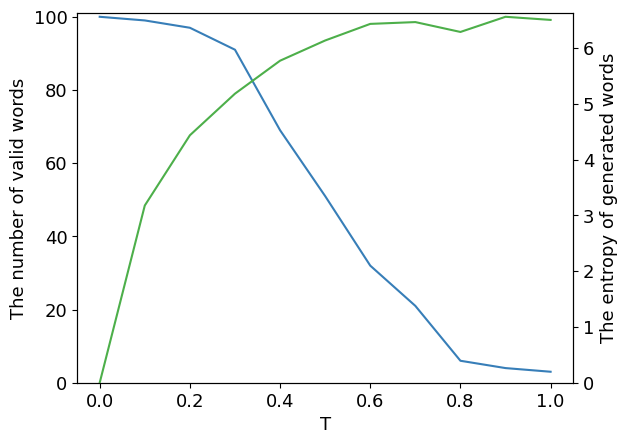

In [19]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(T, vals,
      color=cm.Set1.colors[1])
ax2.plot(T,entropies,
      color=cm.Set1.colors[2])
plt.tick_params(labelsize = 13)
temperature_max = 100
rainfall_max =  max(entropies)
ax1.set_ylim([0, temperature_max + 1 ])
ax2.set_ylim([0, rainfall_max + rainfall_max*0.01 ])
ax1.set_xlabel('T', size=13)
ax1.tick_params(labelsize=13)
ax1.set_ylabel('The number of valid words', size=13)
ax2.set_ylabel('The entropy of generated words', size=13)

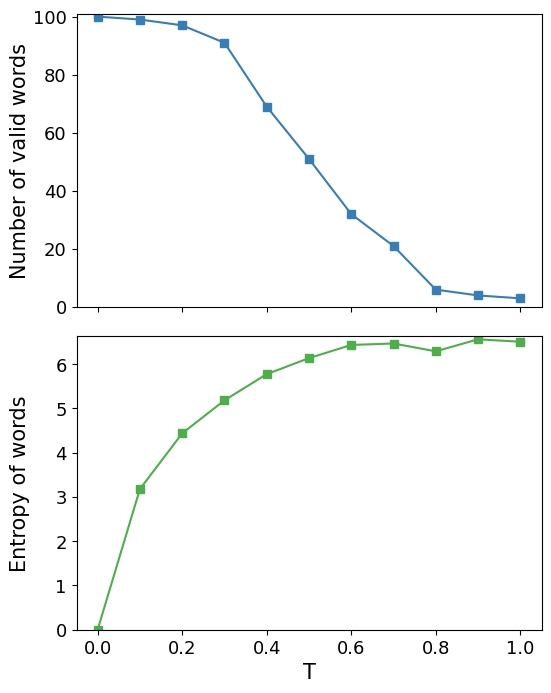

In [20]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
ax1.plot(T, vals, marker='s',
      color=cm.Set1.colors[1])
ax2.plot(T,entropies, marker='s',
      color=cm.Set1.colors[2])

plt.tick_params(labelsize = 13)
temperature_max = 100
rainfall_max =  max(entropies)
ax1.set_ylim([0, temperature_max + 1 ])
ax2.set_ylim([0, rainfall_max + rainfall_max*0.01 ])
ax2.set_xlabel('T', size=15)
ax1.tick_params(labelbottom=False, labelsize=13)
ax2.tick_params(labelsize=13)
ax1.set_ylabel('Number of valid words', size=15)
ax2.set_ylabel('Entropy of words', size=15)
fig.subplots_adjust(hspace=0.1)
ax1.yaxis.set_label_coords(-0.1, 0.5)
ax2.yaxis.set_label_coords(-0.1, 0.5)

### Fig4

In [21]:
print(peony_ws_1, peony_ws_2, len(peony_ws_1))

[[0.04607999999999754, 0.04058999999999902, 0.04800999999999701, 0.04255999999999849, 0.02299000000000378, 0.04846999999999689, 0.04062999999999901, 0.04434999999999801, 0.03250000000000121, 0.037269999999999914, 0.04485999999999787, 0.03929999999999937, 0.02306000000000376, 0.04983999999999652, 0.041289999999998835, 0.06229999999999315, 0.020800000000004374, 0.05002999999999647, 0.03862999999999955, 0.040819999999998954, 0.02232000000000396, 0.03689000000000002, 0.03165000000000144, 0.01952000000000472, 0.02469000000000332, 0.05054999999999633, 9.999999999997296e-15], [1.6051364365901533e-13, 1.6051364365901533e-13, 1.6051364365901533e-13, 1.6051364365901533e-13, 0.5301765650058881, 1.6051364365901533e-13, 1.6051364365901533e-13, 1.6051364365901533e-13, 1.6051364365901533e-13, 1.6051364365901533e-13, 1.6051364365901533e-13, 1.6051364365901533e-13, 1.6051364365901533e-13, 1.6051364365901533e-13, 0.2622792937389915, 1.6051364365901533e-13, 1.6051364365901533e-13, 0.2075441412512673, 1.6

In [22]:
r0 = 0.3
E_maps = np.array([np.zeros([len(x_vals), len(y_vals)]) for i in range(6)])


def calc_(w, x, y, gxy):
  r = np.sqrt((x-gxy[0])**2 + (y-gxy[1])**2)
  E = - 0.5 * np.log(1 + (r/r0)) * w
  return E

for c in range(6):
  for j, (g, gxy) in enumerate(goal_locations.items()):
    for xxx, x in enumerate(x_vals):
      for yyy, y in enumerate(y_vals):
        for i in range(2):
          E1 = calc_(peony_ws_1[c][j], x, y, gxy)
          E2 = calc_(peony_ws_2[c][j], x, y, gxy)
          E_maps[c][xxx][yyy] += E1 + E2

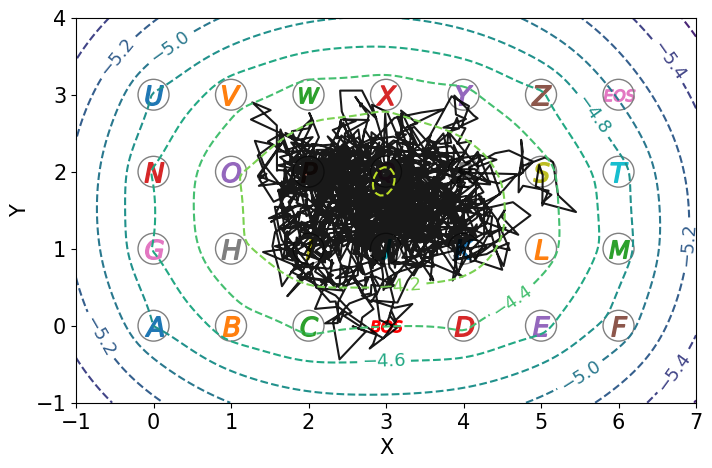

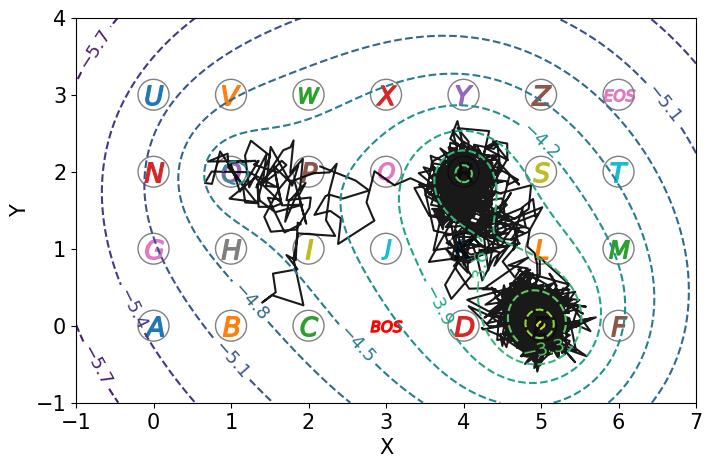

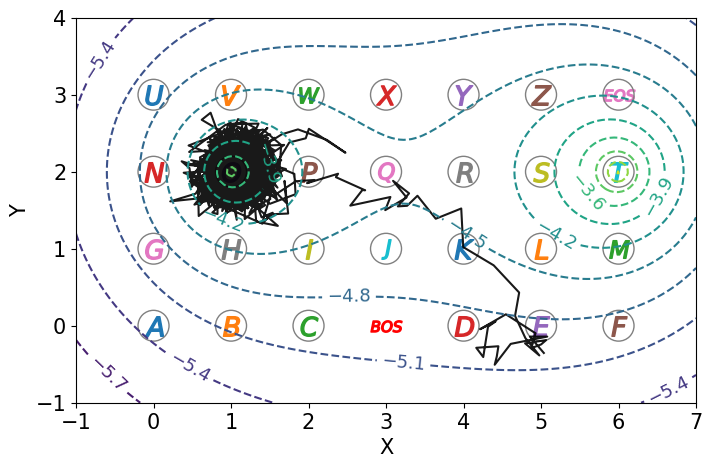

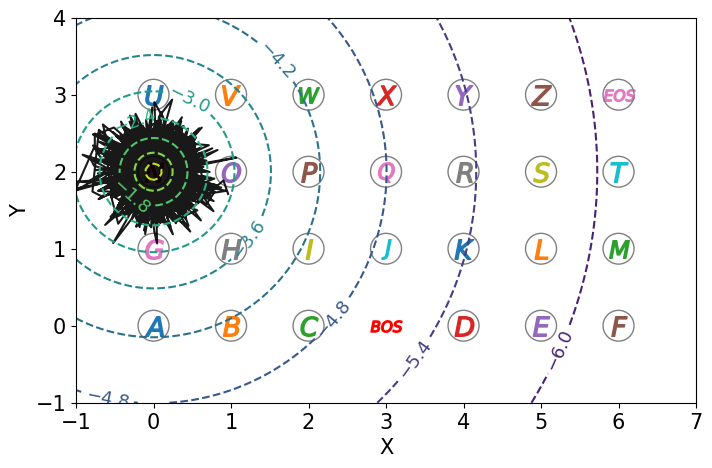

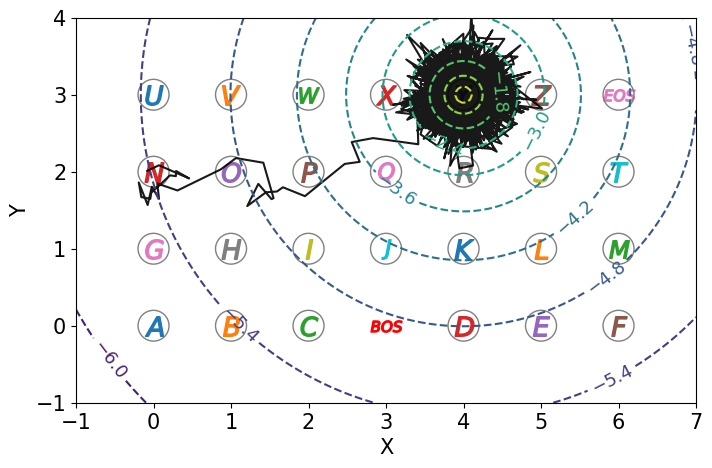

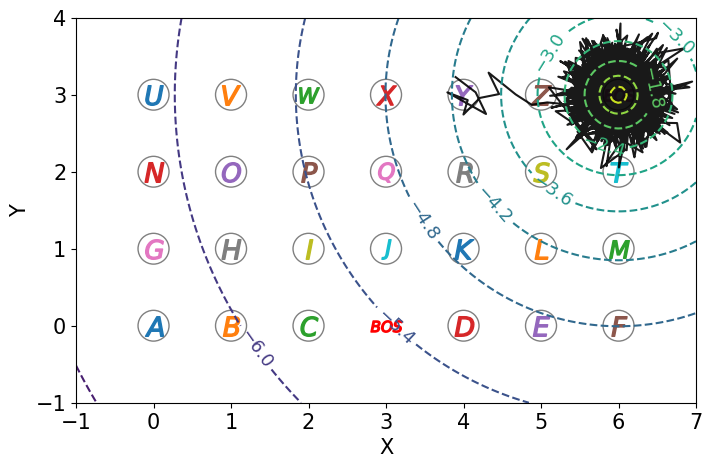

In [24]:
for ii, trajectory_ in enumerate(trajectoryies):
  r_0 = 0.2*scale
  X = np.meshgrid(x_vals, y_vals)
  Z = np.zeros([resolution_y ,resolution_x ])
  fig, ax = plt.subplots(figsize=(8, 5))
  ax.plot(trajectory_[:, 0], trajectory_[:, 1], color="k", alpha=0.9)

  for i, (symbol, goal) in enumerate(goal_locations.items()):
    if i == 26:
      ax.scatter(goal[0], goal[1], marker=plot_letters[i], s=500)
    else:
      ax.scatter(goal[0], goal[1], marker=plot_letters[i], s=200)

    circle = Circle(goal, r_0, fill=False, edgecolor='gray')
    ax.add_patch(circle)

  ax.scatter(initial_position[0], initial_position[1], marker='$BOS$', color='red', s=500)
  contour = ax.contour(X[0], X[1], E_maps[ii].T, levels=10, cmap='viridis', linestyles='dashed')
  ax.clabel(contour, inline=True, fontsize=13)

  ax.set_xlabel("X", size=15)
  ax.set_ylabel("Y", size=15)
  ax.tick_params(labelsize=15)
  ax.set_xlim(-1*scale, grid_size[0])
  ax.set_ylim(-1*scale, grid_size[1])